In [1]:
import os
import logging
import boto3
import zipfile
import json
import io
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO

In [2]:
s3_host = 'https://obj.umiacs.umd.edu'
access_key_id = "xxxxx"
secret_access_key = "xxxxx"

s3 = boto3.client('s3', 
                  endpoint_url=s3_host, 
                  aws_access_key_id=access_key_id, 
                  aws_secret_access_key=secret_access_key)

buntain = 'buntain'


In [3]:
def process(folder_prefix):
    response = s3.list_objects_v2(Bucket=buntain, Prefix=folder_prefix)
    i = 0
    files = []
    for obj in response.get('Contents', []):
        i += 1
        object_key = obj['Key']
        if object_key.endswith('.zip'):
            files.append(object_key)
            # print(f"Processing ZIP file: {object_key}")
    print(f"number of files: {i}")
    dates = []
    for file in files:
        zip_object = s3.get_object(Bucket=buntain, Key=file)
        zip_contents = zip_object['Body'].read()
        zip_file = zipfile.ZipFile(io.BytesIO(zip_contents), 'r')
        for file_info in zip_file.infolist():
            with zip_file.open(file_info) as json_file:
                file_name = file_info.filename
                if not file_name.endswith("-tweet.json"):
                    continue
                # print(file_name)
                try:
                    json_data = json_file.read().decode('utf-8')
                except: 
                    print("this is a text file")
                parsed_data = json.loads(json_data)
                for ind_data in parsed_data:
                    if 'created_at' in ind_data['tweet'].keys():
                        dates.append(ind_data['tweet']['created_at'])
    return pd.to_datetime(dates)


In [4]:
folder_prefix_lst = ['twitter.tmrc/August_2022/TMRC14_APAC_1/', 'twitter.tmrc/August_2022/TMRC14_APAC_2/', 'twitter.tmrc/October_2022/TMRC15_APAC_3/']
dates_lst = []

for folder in folder_prefix_lst:
    print(folder)
    time = process(folder)
    date_time = pd.DataFrame({"tweet_time": time})
    dates_lst.append(date_time)


twitter.tmrc/October_2022/TMRC15_APAC_3/
number of files: 1000


number of total days: 3765, number of total tweets: 131053


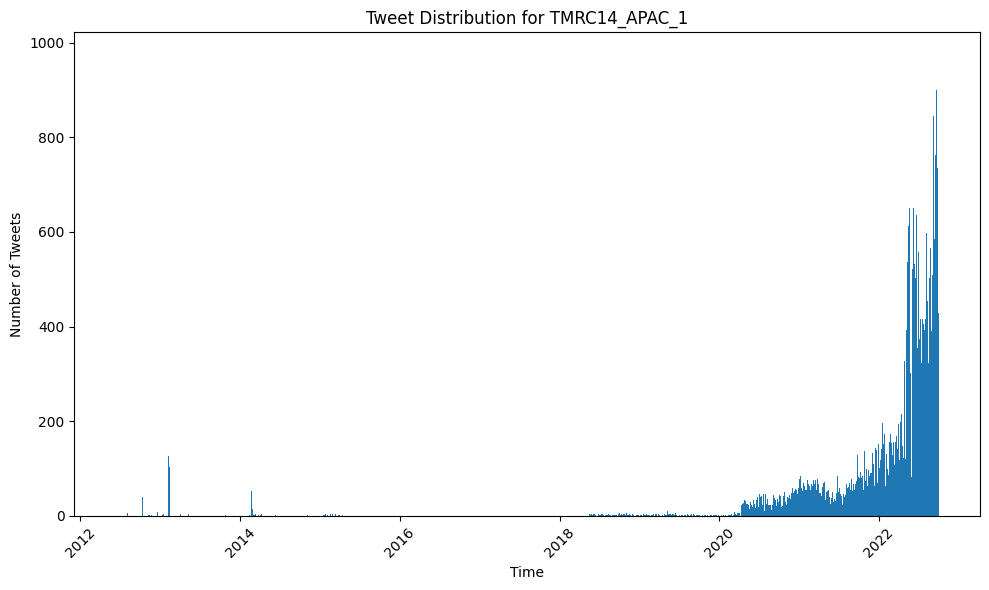

In [5]:
i = 0
for time_df in dates_lst:  
   time_series = time_df["tweet_time"]  
   i+=1
   num_days = int((time_series.max() - time_series.min()).total_seconds() / (60 * 60 * 24))
   bin = int (num_days)
   print(f"number of total days: {bin}, number of total tweets: {len(time_series)}")
   plt.figure(figsize=(10, 6))
   plt.hist(time_series, bins=bin)
   plt.title(f'Tweet Distribution for TMRC14_APAC_{i}')
   plt.xlabel('Time')
   plt.ylabel('Number of Tweets')
   plt.xticks(rotation=45)
   plt.tight_layout()
   plt.show()

In [6]:
i = 0
name = ['TMRC14_APAC_1', 'TMRC14_APAC_2', 'TMRC15_APAC_3']
for time_df in dates_lst:
    time_df.to_csv(f"~/Coding/buntain/time_series_data/{name[i]}.csv", index=False)
    i+=1
